In [91]:
import networkx as nx
import pprint
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [92]:
def generate_exchange_matrix(size: int, graph: nx.Graph) -> list:
    """計算機間の通信コストを表す交流行列を作成する
        通信コストはランダムに決定する
    Args:
        size (int): 行列のサイズ(計算機の数) (size x size).
        graph (nx.Graph): ネットワークトポロジのグラフ表現.

    Returns:
        list: 交流行列
    """
    adj_list = nx.to_dict_of_lists(graph)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i == j:
                matrix[i][j] = 0
            elif j in adj_list[i]:
                matrix[i][j] = random.randint(1, 100)
                matrix[j][i] = matrix[i][j]  # Set symmetric element
            else:
                matrix[i][j] = -1

    for i in range(size):
        for j in range(size):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=matrix[i][j])

    return matrix

In [93]:
def generate_random_graph(num_nodes: int) -> nx.Graph:
    """ランダムなネットワークトポロジーのグラフを作成する

    Args:
        num_nodes (int): ノードの数(計算機の数)

    Returns:
        nx.Graph: ネットワークトポロジーを表すグラフ
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        G.add_edge(i, (i + 1) % num_nodes)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < 0.5:
                G.add_edge(i, j)

    return G


In [94]:
def generate_block_structure(row, col):
    """ニューラルネットワークの構造を表す行列を生成する

    Args:
        row (_type_): 行
        col (_type_): 列

    Returns:
        _type_: ニューラルネットワークの構造を表す行列
        
    Example:
        row = 2, col = 3
        [[0, 2, 4],
        [1, 3, 5]]
    """    
    matrix = [[j * row + i for j in range(col)] for i in range(row)]
    return np.array(matrix)

In [95]:
def weightintg_graph(graph: nx.Graph, exchange_matrix: list):
    """交流行列からネットワークトポロジーのグラフに重み(通信コスト)を付ける

    Args:
        graph (nx.Graph): トポロジーを表すグラフ
        exchange_matrix (list): 計算期間の通信コストを表す交流行列
    """
    num_nodes = len(exchange_matrix)
    adj_list = nx.to_dict_of_lists(graph)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=exchange_matrix[i][j])

In [96]:
def create_block_matrix(num_rows: int, num_cols: int) -> list:
    """ニューラルネットワークを分割したブロックの接続関係を表す行列を作成

    Args:
        num_rows (int): 分割ブロックの行数
        num_cols (int): 分割ブロックの列数

    Returns:
        list: ブロック間の接続を表す行列
        
    Example:
        num_rows = 2, num_cols = 3の場合
        -----
        1 3 5
        2 4 6
        -----
        
        となり接続関係は以下のようになる
        接続関係を持っていれば1, なければ0
        --------------------
        [[0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 0]]
        --------------------
    """
    matrix_size = num_rows * num_cols
    matrix = [[0] * matrix_size for _ in range(matrix_size)]

    # Helper function to check if a block is within the matrix bounds
    def is_valid_block(row, col):
        return 0 <= row < num_rows and 0 <= col < num_cols

    # Iterate over each block in depth-first order
    for block in range(matrix_size):
        col = block // num_rows
        row = block % num_rows

        # Connect to vertical neighbors
        if is_valid_block(row - 1, col):
            neighbor = (col * num_rows) + (row - 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row + 1, col):
            neighbor = (col * num_rows) + (row + 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to horizontal neighbors
        if is_valid_block(row, col - 1):
            neighbor = ((col - 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row, col + 1):
            neighbor = ((col + 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to diagonal neighbors
        if is_valid_block(row - 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row - 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1

    return matrix


In [97]:
def generate_block_list(num_blocks: int) -> list:
    """分割したブロックの番号リスト

    Args:
        num_nodes (int): 分割ブロックの数

    Returns:
        list: ブロックの番号リスト
        
    Example:
        num_blocks = 6の場合
        ------------------
        [0, 1, 2, 3, 4, 5]
        ------------------
    """    
    block_list = []
    for i in range(num_blocks):
        block_list.append(i)
    return block_list

In [98]:
def generate_pc_capacity_list(num_pcs: int, num_blocks: int) -> list:
    """計算機のキャパシティを表すリストを作成
    
    足し合わせるとnum_

    Args:
        pc_nums (int): 計算機の数

    Returns:
        list: 計算機の処理できるブロック数のリスト
        
    Exapmle:
        pc_nums = 4の場合
        Capacities = [1, 3, 2, 5]
        C[0] = 1, C[1] = 3, C[2] = 2, C[3] = 5
        PC1の処理できるブロック数は1
        PC2の処理できるブロック数は3
    """
    capacities = []

    for _ in range(num_pcs - 1):
        num = random.randint(1, num_blocks//2)
        capacities.append(num)
        num_blocks -= num


    capacities.append(random.randint(num_blocks, num_blocks+3))

    return capacities


In [99]:
def generate_random_assignment(num_pcs: int, num_blocks: int, capacities: list) -> list:
    """各ブロックを担当する計算機をランダムに割り当てたリスト

    Args:
        num_pcs (int): 計算機の数
        num_blocks (int): ブロックの数
        capacities (list): 各計算機のキャパシティ

    Returns:
        list: ブロックを担当する計算機のリスト
        
    Example:
        [2, 0, 0, 3, 3, 0, 1, 3, 3, 3, 1, 2]
        
        -> ブロック0はPC2が担当
        -> ブロック1はPC0が担当
    """
    assignment = []
    counts = Counter()

    # キャパシティごとの最大割り当て可能数を計算
    max_counts = {pc: min(num_blocks, capacity) for pc, capacity in enumerate(capacities)}

    # 割り当てる要素をランダムに選びながら、キャパシティを超えないように制限
    for _ in range(num_blocks):
        available_pcs = [pc for pc in range(num_pcs) if counts[pc] < max_counts[pc]]
        selected_pc = random.choice(available_pcs)
        assignment.append(selected_pc)
        counts[selected_pc] += 1

    # 乱数をシャッフル
    random.shuffle(assignment)

    return assignment

In [100]:
def find_max_index(lst):
    max_value = max(lst)  # リスト内の最大値を取得
    max_index = lst.index(max_value)  # 最大値の添字を取得
    return max_value, max_index


In [101]:
def get_positive_min(lst: list, used_pcs: list) -> int:
    """リストから0より大きい最小値を取得

    Args:
        lst (_type_): 探索対象のリスト

    Returns:
        _type_: 最小値
    """
    positive_values = [(i, x) for i, x in enumerate(lst) if x > 0 and i not in used_pcs]
    if positive_values:
        sorted_values = sorted(positive_values, key=lambda x: x[1])
        min_index, _ = sorted_values[0]
        return min_index
    else:
        return None


In [102]:
def generate_greedy_assignment(num_pcs: int, num_blocks: int, capacities: list, exchange_matrix: list) -> list:
    """グリーディーに割り当てを実施する

    Args:
        num_pcs (int): 計算機の第数
        num_blocks (int): ブロックの数
        capacities (list): 計算機のキャかシティ
        exchange_matrix (list): 交流行列

    Returns:
        list: 割り当て結果
    """    
    assignment = [-1] * num_blocks  # 割り当てを表すリスト
    used_pcs = []  # 割り当て済み(使用済み)の計算機のリスト

    # 1. キャパの一番大きいPCを探す
    max_capacity = max(capacities)
    initial_pc = capacities.index(max_capacity)
    used_pcs.append(initial_pc)  # 最大キャパシティの計算機を使用済みリストに追加

    # 2. (1)のPCを始点としてキャパ分のブロックを割り当てる
    for i in range(max_capacity):
        assignment[i] = initial_pc

    count = max_capacity  # 割り当て済みのブロック数

    # 3. 4. をすべてのブロックをなくなるまで繰り返す
    while count < num_blocks:
        next_pc = get_positive_min(exchange_matrix[initial_pc], used_pcs=used_pcs)  # 通信コストが低いPC
        if next_pc is None:
            # 計算機の探索が不可能な場合、未使用のPCの中で最大の容量を持つPCを現在のPCとする
            remaining_pcs = set(range(num_pcs)) - set(used_pcs)
            next_pc = max(remaining_pcs, key=lambda pc: capacities[pc])

        used_pcs.append(next_pc)  # 使用済みリストに追加

        # 4. (3)のPCにブロックをキャパ分、割り当てる
        for i in range(capacities[next_pc]):
            if count >= num_blocks:
                break
            assignment[count] = next_pc
            count += 1

    return assignment


In [103]:
def get_pc_by_block_label(block_label: int, assigned_matrix: list) -> int:
    """ブロックのラベルから担当する計算機の番号を返す

    Args:
        block_label (int): ブロックのラベル
        task_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: 計算機の番号
    """
    pc_num = len(assigned_matrix)
    for i in range(pc_num):
        if i == block_label:
            return assigned_matrix[i]
    

In [104]:
def get_tasks_by_pc(pc: int, assigned_matrix: list) -> int:
    """計算機の番号から担当するブロックのラベルを返す

    Args:
        block_label (int): ブロックのラベル
        assigned_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: ブロックのラベル
    """
    tasks = []
    for i in range(len(assigned_matrix)):
        if pc == assigned_matrix[i]:
            tasks.append(i)
    return tasks

In [105]:
def generate_linked_block_list(matrix: list) -> list:
    """接続しているブロック(結果を送信する必要のある)のラベルのリストを返す

    Args:
        matrix (list): ブロックの配置を表す行列

    Returns:
        list: 各ブロックが結果を送信する必要のあるブロック
        
    Example:
        output:
            B = [[1, 2, 3], [0, 2, 3], [3, 4, 5], [2, 4, 5], [5], [4]]
            
        B[0] = [1, 2, 3]
        ブロック0はブロック1, 2, 3に結果を送信する必要がある
    """
    result = []
    n_cols = matrix.shape[1]

    for j in range(n_cols):
        current_column = matrix[:, j]
        next_column = matrix[:, j + 1] if j < n_cols - 1 else []
        column_elements = [list(set(current_column) - set([current_column[i]])) + list(next_column) for i in range(len(current_column))]
        result.extend(column_elements)
        
    return result

In [106]:
def evaluate_communication_cost(block_list: list, assigned_matrix: list, linked_blocks: list, G) -> float:
    """割り当て結果から順伝播させた時の通信コストを計算する

    Args:
        block_list (list): ブロック分割のリスト
        assigned_matrix (list): ニューロンに計算機を割り当てたリスト
        linked_blocks (list): ブロックの接続関係を表すリスト

    Returns:
        float: 総通信コスト
    """    
    total_cost = 0
    for temp_label in block_list:
        # print(temp_label)

        # 始点のPCを取得
        initial_pc = get_pc_by_block_label(block_label=temp_label, assigned_matrix=assigned_matrix)
        # 順伝搬させた時の総通信コストを計算
        # print(f'ブロック{temp_label}を担当するPC: {initial_pc}')
        
        # temp_labelと接続しているブロックのリストを取得
        linked_list = linked_blocks[temp_label]
        # print(f'ブロック{temp_label}と接続しているブロックの番号リスト: {linked_list}')

        # 送信対象のPCを取得
        target_pcs = [get_pc_by_block_label(block_label=linked_block, assigned_matrix=assigned_matrix) for linked_block in linked_list]
        # print(f'ブロック{temp_label}の送信対象のPCの番号リスト: {target_pcs}')

        # 送信対象のPCのリストから重複を削除
        target_pcs = list(set(target_pcs))
        # print(f'ブロック0の送信対象のPCの番号リスト(重複削除後): {target_pcs}')

        # 総通信コストを計算
        temp_cost = 0
        for target in target_pcs:
            length = nx.dijkstra_path_length(G, initial_pc, target)
            # print(length)
            temp_cost += length
        total_cost += temp_cost
        # print(f'ブロック{temp_label}の総通信コスト: {temp_cost}\n')
    # print(f'総通信コスト: {total_cost}')
    return total_cost

ニューラルネットワークの構造を表した行列:
[[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
   36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
   72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
  108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
  144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
  180 182 184 186 188 190 192 194 196 198]
 [  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
   37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
   73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
  109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
  145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
  181 183 185 187 189 191 193 195 197 199]]

交流行列
[[ 0. 37. -1. 64. -1. -1. 29. 95. -1. 55.]
 [37.  0.  9. 38. -1. -1. 81. -1. -1. 17.]
 [-1.  9.  0. 70. 18. -1. 64. 14. -1. -1.]
 [64. 38. 70.  0

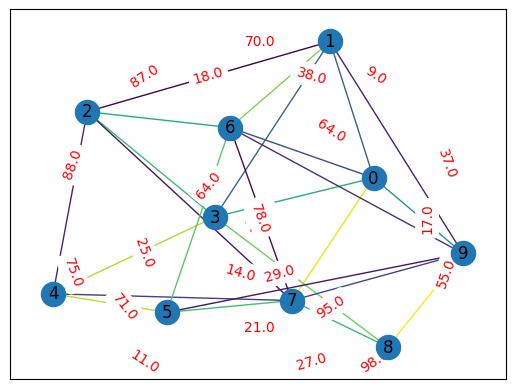

In [107]:
# ネットワークトポロジーを作成
num_pcs = 10
num_blocks = 200
structure_row = 2
structure_col = num_blocks // structure_row

G = generate_random_graph(num_pcs)
# 交流行列を作成
exchange_matrix = generate_exchange_matrix(size=num_pcs, graph=G)
capacities = generate_pc_capacity_list(num_pcs=num_pcs, num_blocks=num_blocks)

# グラフのエッジに通信コスト(交流行列より)を付与
weightintg_graph(G, exchange_matrix)

# グラフの描画
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, edge_color = weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# ニューラルネットワークを分割したブロック
block_structure = generate_block_structure(row=structure_row, col=structure_col)
print(f'ニューラルネットワークの構造を表した行列:\n{block_structure}\n')

# 通信する必要のあるブロックのリストを作成
linked_blocks = generate_linked_block_list(block_structure)


print("交流行列")
print(exchange_matrix)

# block_linked_matrix = create_block_matrix(num_rows=2, num_cols=3)
print("\nニューラルネットワークの分割ブロックの接続関係を表す行列")
pprint.pprint(linked_blocks)

block_list = generate_block_list(num_blocks=num_blocks)
print("\n分割ブロックの番号リスト")
print(block_list)

# Distribute tasks to computers
random_assigned_matrix = generate_random_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=capacities)
greedy_assigned_matrix = generate_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=capacities, exchange_matrix=exchange_matrix)
print("計算機のキャパシティを表すリスト")
print(capacities)
print("\nPCが担当するブロックの割り当てを表す行列")
print(f'Group = {random_assigned_matrix}')
print(f'Group = {greedy_assigned_matrix}')

In [108]:

print(f'PCのキャパシティ:\n {capacities}\n')

random_total_cost = evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=random_assigned_matrix, G=G)
print(f'ランダムに割り当て:\n{random_assigned_matrix}')
print(f'ランダムに割り当てた場合の総通信コスト: {random_total_cost}\n')

greedy_total_cost = evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=greedy_assigned_matrix, G=G)
print(f'グリーディーに割り当て:\n{greedy_assigned_matrix}')
print(f'グリーディーに割り当てた場合の総通信コスト: {greedy_total_cost}')

PCのキャパシティ:
 [6, 27, 24, 53, 35, 17, 7, 10, 4, 19]

ランダムに割り当て:
[1, 3, 4, 4, 4, 3, 1, 3, 3, 2, 7, 4, 0, 3, 1, 0, 0, 3, 3, 9, 2, 1, 4, 5, 4, 4, 5, 3, 3, 9, 3, 4, 3, 2, 4, 7, 2, 5, 1, 9, 9, 4, 5, 3, 7, 1, 4, 1, 3, 9, 4, 2, 1, 5, 1, 5, 9, 5, 9, 4, 1, 7, 4, 1, 2, 4, 1, 9, 2, 4, 2, 3, 2, 1, 7, 9, 3, 2, 3, 3, 6, 3, 5, 5, 9, 3, 1, 8, 6, 3, 2, 5, 2, 3, 9, 7, 3, 2, 5, 4, 9, 4, 0, 1, 3, 1, 6, 4, 3, 7, 5, 3, 4, 2, 1, 3, 2, 6, 0, 2, 3, 2, 3, 1, 3, 8, 3, 6, 3, 6, 2, 4, 3, 8, 4, 3, 3, 3, 7, 5, 1, 4, 1, 0, 3, 4, 6, 2, 3, 2, 2, 9, 3, 2, 9, 4, 4, 5, 3, 9, 3, 2, 4, 4, 3, 3, 4, 3, 4, 4, 8, 5, 9, 7, 4, 3, 3, 4, 3, 1, 3, 1, 2, 7, 5, 3, 1, 9, 9, 4, 5, 1, 3, 1, 4, 1, 1, 9, 3, 3]
ランダムに割り当てた場合の総通信コスト: 19913.0

グリーディーに割り当て:
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,